# Morphology Classification using a Random Forest Classifier

Tutorial 1b -- AAS 237 Hands-on Machine Learning for Astronomers Workshop, January 7&8, 2021

This notebook contains the random forest classifier we use to perform a morphological classification of a subset of CANDELS GOODS-S galaxies. Kartaltepe et al. (2015, https://ui.adsabs.harvard.edu/abs/2015ApJS..221...11K/abstract) describes the sample, and the visual classification scheme employed on the parent sample in detail. We make use of this parent sample to derive a subset mainly consisting of two morphology types, spheroids and disks, selected via the following prescription:

if ['f_Dk_'] > 0.90 & ['f_Sph_'] < 0.30 --> Morphology = Disk, class_label = 1

if ['f_Sph_'] > 0.90 & ['f_Dk_'] < 0.30 --> Morphology = Spheroid, class_label = 0

where f_Dk_ and f_Sph_ is the fraction of classifiers that designated that a given galaxy has a disk or spheroid morphology, respectively. The goal of this tutorial is to determine whether a convolutional neural network model could be capable of performing high accuracy classification of these two classes. Note that the data selection from the CANDELS catalog has already been performed, and in this notebook we only read in pickle files that contain this subset.

Note: Please also see the presentation accompanying this notebook for some extra details.

Author & Contact: Sinan Deger, sdeger@caltech.edu


In [1]:
import os
import sys
from time import clock
from os import path
"""Import the basics; numpy, pandas, matplotlib et al."""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
"""Import scikit learn tools"""
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

First, we read the catalog that contains the morphology parameters of our sample. We used the Astropy affiliated package _statmorph_ (https://statmorph.readthedocs.io/en/latest/) detailed in Rodriguez-Gomez et al. (2019, https://ui.adsabs.harvard.edu/abs/2019MNRAS.483.4140R) to extract the following features of the galaxies in our sample (definitions from the _statmorph_ API Reference):


concentration

    Calculate concentration as described in Lotz et al. (2004).
    
    
asymmetry

    Calculate asymmetry as described in Lotz et al. (2004).


smoothness

    Calculate smoothness (a.k.a. clumpiness) as defined in eq. (11) from Lotz et al. (2004). Note that the original definition by Conselice (2003) includes an additional factor of 10.


r20

    The radius that contains 20% of the light within ‘petro_extent_cas’ (usually 1.5) times ‘rpetro_circ’.
    

r80

    The radius that contains 80% of the light within ‘petro_extent_cas’ (usually 1.5) times ‘rpetro_circ’.


rhalf_circ

    The radius of a circular aperture containing 50% of the light, assuming that the center is the point that minimizes the asymmetry and that the total is at rmax_circ.


rhalf_ellip

    The semimajor axis of an elliptical aperture containing 50% of the light, assuming that the center is the point that minimizes the asymmetry and that the total is at rmax_ellip.


sersic_n

    The Sersic index n (astropy.modeling.models.Sersic2D).
   



In [2]:
"""Read the morphology and the partial CANDELS GOODS-S merged catalog"""
morph_df_base = pd.read_csv('../data/AAS237_morphology_catalog.csv')
"""Select only the galaxies for which statmorph does not raise a flag for the Sersic fit"""
morph_df = morph_df_base.loc[morph_df_base['sersic_flag'] == 0].copy()

print('Length of the initial catalog:', morph_df_base.shape[0])
print('Length after sersic_flag == 0 selection made:', morph_df.shape[0])

"""
Reminder:
###################################################################################
Descriptions of our classes:

if ['f_Dk_'] > 0.90 & ['f_Sph_'] < 0.30 --> Morphology = Disk, class_label = 1

if ['f_Sph_'] > 0.90 & ['f_Dk_'] < 0.30 --> Morphology = Spheroid, class_label = 0
###################################################################################
"""

"""Number of galaxies in each morphology class"""
print('Number of galaxies with early type morphology:', morph_df.loc[morph_df['morphology'] == 0].shape[0])
print('Number of galaxies with late type morphology:', morph_df.loc[morph_df['morphology'] == 1].shape[0])



Length of the initial catalog: 2119
Length after sersic_flag == 0 selection made: 1775
Number of galaxies with early type morphology: 353
Number of galaxies with late type morphology: 1422


In [3]:
"Next, we select the columns we would like to use for the fitting procedure"
feature_columns = ['C', 'A', 'S', 'r20', 'r80', 'sersic_index', 'rhalf_circ', 'rhalf_ellip']
full_rfc_df = morph_df.dropna().copy()

X_df = full_rfc_df[feature_columns].copy()
X = X_df.values
"""X: numpy array containing the values from the feature list for the morphology sample"""
y_df = full_rfc_df['morphology'].copy()
y = y_df.values
"""Y: numpy array containing the morphology labels of the morphology sample"""

"""
Similar to Tutorial 1a, we use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples.

"""
skf = StratifiedShuffleSplit(n_splits=2, test_size=0.15, random_state=42)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print('Number of objects classified as spheroid in the training sample: ',
      len(np.unique(np.where(y_train == 0)[0])))

print('Number of objects classified as disk in the training sample: ',
      len(np.unique(np.where(y_train == 1)[0])))
    

Number of objects classified as spheroid in the training sample:  300
Number of objects classified as disk in the training sample:  1208


Having selected our training and test samples, we now proceed with our decision tree based classification scheme. To this effect, we use the RandomForestClassifier module within scikit learn, called below. Note that the majority of the parameters in this function call has been left at their default values. We display these here for visualization purposes.  

Feature ranking:
1. feature r20 (0.239891)
2. feature rhalf_ellip (0.206148)
3. feature r80 (0.139508)
4. feature sersic_index (0.122152)
5. feature C (0.116845)
6. feature rhalf_circ (0.089820)
7. feature S (0.043308)
8. feature A (0.042327)


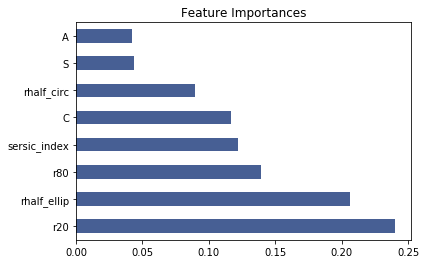

In [4]:
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
                             min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None,
                             random_state=42, verbose=0, warm_start=False, class_weight=None)


clf.fit(X_train, y_train)

"""We plot the feature importance chart of the random forest classifier here"""

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

"""Print the rankings of our features, showing how important they were for the fitting"""
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_columns[indices[f]], importances[indices[f]]))

"""Finally, we visualize these rankings in the figure showing impurity-based feature importances of the forest"""
plt.figure()
plt.title("Feature Importances")
pd.Series(clf.feature_importances_, index=X_df.columns).sort_values().plot(kind='barh', color="#475f94").invert_yaxis()
plt.show()

In [5]:
"""We finalize this tutorial by having our trained classifier predict the morphology class of our test sample"""

print('Fraction of correct predictions with scikit-learn random forest classifier: ',
      round(accuracy_score(clf.predict(X_test), y_test), 2))

Fraction of correct predictions with scikit-learn random forest classifier:  0.95
